## Fine-Tuning a Pretrained VGG16 Convolutional Network

This notebook should be run in Google Colab with a GPU

### Preliminaries

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2.5,2.5)  # set default figure size

In [ ]:
# generalized version of plot_history that plots validation data if available
def plot_history(history):
    loss_values = history.history['loss']
    accuracy_values = history.history['accuracy']
    validation = 'val_loss' in history.history
    if validation:
        val_loss_values = history.history['val_loss']
        val_accuracy_values = history.history['val_accuracy']
    epoch_nums = range(1, len(loss_values)+1)
    plt.figure(figsize=(12,4)) # width, height in inches
    plt.subplot(1, 2, 1)
    if validation:
        plt.plot(epoch_nums, loss_values, 'r', label="Training loss")
        plt.plot(epoch_nums, val_loss_values, 'r--', label="Validation loss")
        plt.title("Training/validation loss")
        plt.legend()
    else:
        plt.plot(epoch_nums, loss_values, 'r', label="Training loss")
        plt.title("Training loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.subplot(1, 2, 2)
    if validation:
        plt.plot(epoch_nums, accuracy_values, 'b', label='Training accuracy')
        plt.plot(epoch_nums, val_accuracy_values, 'b--', label='Validation accuracy')
        plt.title("Training/validation accuracy")
        plt.legend()
    else:
        plt.plot(epoch_nums, accuracy_values, 'b', label='Training accuracy')
        plt.title("Training accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.show()

def show_random_image(images):
    i = random.randrange(len(images))
    print(f"image {i}")
    plt.imshow(images[i])

def show_random_selection(images):
    indices = range(len(images))
    plt.figure(figsize=(15,12))  # (width, height) in inches
    rows, columns = 5, 6
    for k in range(1, columns*rows+1):
        i = random.choice(indices)
        plt.subplot(rows, columns, k)
        plt.axis('off')
        plt.imshow(images[i])

from tensorflow.keras.models import Model

# general-purpose utility function to display feature maps for an input image
def show_features(network, image, layer_name, features=range(20), cmap='gray', cols=5):
    # features can be a number like 0 or a sequence like [0, 2, 4] or range(10)
    vgg16 = network.get_layer('vgg16')
    layer_names = [layer.name for layer in vgg16.layers]
    if layer_name not in layer_names:
        print(f"No such VGG16 layer: {layer_name}")
        return
    # generate features for layer_name using tensors
    input_tensor = vgg16.layers[0].input
    output_tensor = vgg16.get_layer(layer_name).output
    model = Model(inputs=input_tensor, outputs=output_tensor)
    input_batch = np.array([preprocess_input(image)])
    output_batch = np.array(model(input_batch))
    output = output_batch[0]
    h, w, d = output.shape
    # display image
    plt.axis('off')
    plt.imshow(image)
    # display feature maps
    if type(features) is int:
        features  = [features]
    rows = len(features) // cols
    if len(features) > rows*cols:
        rows += 1
    fig = plt.figure(figsize=(13, 13/cols*rows))
    i = 1
    for feature in features:
        if 0 <= feature < d:
            fig.add_subplot(rows, cols, i)
            i += 1
            plt.imshow(output[:,:,feature], cmap=cmap)
            plt.title(f"feature {feature}")
            plt.axis('off')

### Building and Training a New Network Based on VGG16

The advantage of using a large pretrained network like VGG16 is that it has already been trained on a large dataset of real-world images (> 1.4 million in the case of ImageNet).  The network's convolutional layers have learned to recognize many low-level visual features shared by almost all visual scenes, such as edges separating light and dark regions, line segments of specific orientations, corners, intersections, visual textures, etc.

These general elements are common to many types of visual recognition tasks, such as distinguishing cats from dogs.  Rather than re-training a large network from scratch on each new visual recognition task, a better approach is to re-use a pretrained network by harnessing and "fine tuning" its convolutional layers according to the specific task at hand.

We will build a new network to classify cats vs. dogs, based on the pretrained VGG16 network.  For this task, we will use a larger dataset of 2000 color images of cats and dogs of size 150 &times; 150.  First, let's download the data:

In [ ]:
!curl -O science.slc.edu/jmarshall/bioai/data/cats_dogs_2000_150x150.npz

In [ ]:
f = np.load('cats_dogs_2000_150x150.npz')

In [ ]:
list(f.keys())

In [ ]:
images, labels = f['images'], f['labels']

In [ ]:
images.shape

In [ ]:
images.dtype, images.min(), images.max()

In [ ]:
labels.shape

In [ ]:
labels

In [ ]:
cats, dogs = images[0:1000], images[1000:2000]

In [ ]:
plt.imshow(cats[0]);

In [ ]:
plt.imshow(dogs[0]);

In [ ]:
show_random_selection(dogs)

### The Convolutional Base

We will use only the VGG16's convolutional layers.  The parameter `include_top=False` omits the classification layers of the VGG16 network.  Because the number of convolutional weights in a ConvNet does not depend on the input image size, our input images are not restricted to being 224 &times; 224.  The output shape of the VGG16 module is unspecified, as are the sizes of the convolutional and pooling layers.  

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
vgg16_base = VGG16(weights='imagenet', include_top=False)

In [ ]:
vgg16_base.summary()

We will fine-tune the last few convolutional layers of the VGG16 base while simultaneously training new classification layers on top of it for classifying cats and dogs.  We will follow these steps:

1. Add the classification network on top of the pretrained convolutional base.

2. Freeze the convolutional base weights.

3. Train the classification weights.

4. Unfreeze some of the convolutional layers.

5. Jointly train the unfrozen convolutional layers and the classification layers.

#### Step 0: Prepare the data

The first 1000 images are of cats (label=0), and the last 1000 are of dogs (label=1).

In [ ]:
images.shape

In [ ]:
labels[900:1100]

Randomly shuffle the data and divide it into training, validation, and test sets.

In [ ]:
np.random.permutation(10)

In [ ]:
shuffled_indices = np.random.permutation(2000)
images = images[shuffled_indices]
labels = labels[shuffled_indices]

In [ ]:
shuffled_indices

In [ ]:
labels[900:1100]

In [ ]:
# 1000 training images
train_images = images[0:1000]
train_targets = labels[0:1000].astype('float32') # targets must be probabilities

# 500 validation images
val_images = images[1000:1500]
val_targets = labels[1000:1500].astype('float32')

# 500 test images
test_images = images[1500:2000]
test_targets = labels[1500:2000].astype('float32')

#### Step 1: Add the classification network on top of the pretrained VGG16 base

We will use a fully-connected hidden layer of 256 rectified linear (ReLU) units, followed by a "Dropout" layer to improve the network's generalization ability.  Since our network will be doing two-way classification, we will use a single sigmoid output unit.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda, Flatten, Dense, Dropout
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def build_network():
    network = Sequential()
    network.add(Lambda(preprocess_input, input_shape=(150,150,3)))
    network.add(VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3)))
    network.add(Flatten())
    network.add(Dense(256, activation='relu'))
    network.add(Dropout(0.5))  # improves the performance of the network
    network.add(Dense(1, activation='sigmoid'))
    return network

In [ ]:
network = build_network()

In [ ]:
network.summary()

#### Dropout layers

Dropout layers introduce stochastic noise into the training process by temporarily "zeroing-out" a randomly-chosen subset of the weights on each training cycle.  The particular set of zeroed-out weights changes on each cycle.  Once training is finished, dropout no longer occurs, and the full set of trained weights are used to compute the network's response to each input.  The dropout parameter (0.5 in the network above) specifies the fraction of network weights that are zeroed-out on each training step.

Srivastava, Hinton, Krizhevsky, Sutskever, Salakhutdinov, "Dropout: A Simple Way to Prevent Neural Networks from Overfitting", *Journal of Machine Learning Research* **15**, 2014, pp. 1929-1958.

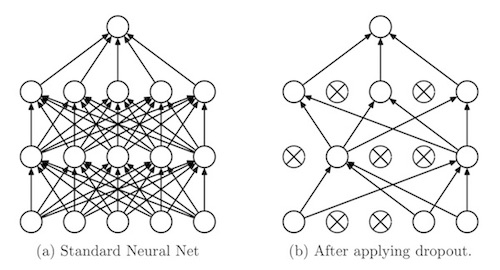

#### Step 2: Freeze the convolutional base weights

In [ ]:
network.layers

In [ ]:
vgg16_base = network.layers[1]

In [ ]:
vgg16_base.trainable

In [ ]:
vgg16_base.summary() # note the number of trainable parameters listed at the bottom

In [ ]:
vgg16_base.trainable = False

In [ ]:
vgg16_base.trainable

In [ ]:
vgg16_base.summary() # note the number of trainable parameters listed at the bottom

In [ ]:
network.summary() # note the number of trainable parameters listed at the bottom

#### Step 3: Train the classification weights

In [ ]:
network.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
history = network.fit(train_images, train_targets,
                      validation_data=(val_images, val_targets),
                      epochs=5)

In [ ]:
plot_history(history)

In [ ]:
network.evaluate(val_images, val_targets)

In [ ]:
network.evaluate(test_images, test_targets)

#### Step 4: Unfreeze some of the convolutional layers of the VGG16 base

We will unfreeze the weights in the layers named `block5_conv1`, `block5_conv2`, and `block5_conv3`.

In [ ]:
vgg16_base.trainable = True

In [ ]:
for layer in vgg16_base.layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

<font color=red>**IMPORTANT:**</font> Always re-compile the network after freezing or unfreezing weights!

In [ ]:
network.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
for layer in vgg16_base.layers:
    print(f'{layer.name}: {layer.trainable}')

In [ ]:
vgg16_base.summary() # note the number of trainable parameters listed at the bottom

In [ ]:
print(2359808*3, "trainable parameters in the VGG16 base")

In [ ]:
network.summary()

In [ ]:
print(7079424 + 2097408 + 257, "trainable parameters in the whole network")

#### Step 5: Jointly train the unfrozen convolutional layers and the classification layers

In [ ]:
from tensorflow.keras.optimizers import RMSprop

network.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=0.00001), # use a smaller learning rate
                metrics=['accuracy'])

In [ ]:
history = network.fit(train_images, train_targets,
                      validation_data=(val_images, val_targets),
                      epochs=3)

In [ ]:
network.evaluate(val_images, val_targets)

In [ ]:
network.evaluate(test_images, test_targets)

Pick a new image at random and classify it:

In [ ]:
new_image = random.choice(test_images)

In [ ]:
plt.imshow(new_image);

In [ ]:
new_output = network.predict(np.array([new_image]))  # a batch with one image

In [ ]:
new_output.shape

In [ ]:
new_output

In [ ]:
def cat_or_dog(image):
    plt.imshow(image)
    output = network.predict(np.array([image]))  # a batch with one image
    print('MEOW!') if output < 0.5 else print('WOOF!')

In [ ]:
cat_or_dog(new_image)

In [ ]:
def cat_or_dog(image):
    plt.axis('off')   # added
    plt.imshow(image)
    output = network.predict(np.array([image]), verbose=0)  # added verbose=0
    print('MEOW!') if output < 0.5 else print('WOOF!')

In [ ]:
cat_or_dog(new_image)

In [ ]:
cat_or_dog(random.choice(test_images))

In [ ]:
show_features(network, random.choice(test_images), 'block1_conv1')

In [ ]:
show_features(network, random.choice(test_images), 'block5_conv3')

In [ ]:
show_features(network, random.choice(test_images), 'block5_pool')